# Wilkens LET model
Bortfeld analytical approximation of proton stopping power in water:

$$
\tilde S(r)  = \frac{r^{1/p - 1}}{p \alpha^{1/p}}
$$

where $r$ is the residual range ($R_0-z$).

Bragg-Kleeman rule which relates range of protons with its initial kinetic energy employs the same constants $p$ and $\alpha$:

$$
R_0(E) = \alpha E^p
$$

In [1]:
# jupyter hacks to print some command output (i.e. %psource) in the cell, instead of in popup
from __future__ import print_function
from IPython.core import page
page.page = print

# first some necessary python imports
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# most of the code is stored in models.py file
# we import it here and display the source code of the stopping power & range calculator class
from models import ERSCalc
%psource ERSCalc

class ERSCalc(object):
    """
    A 'calculator' class for stopping power and range of protons
    """
    alpha_cm_MeV = 0.0022
    p = 1.77

    @classmethod
    def p_alpha_cm_MeV(cls):
        """
        Helper variable p*alpha^(1/p)
        """
        return cls.p * cls.alpha_cm_MeV ** (1.0 / cls.p)

    @classmethod
    def range_cm(cls, energy_MeV):
        """
        Bragg-Kleeman rule for energy-range relationship
        Equation (8) in [1]
        """
        return cls.alpha_cm_MeV * energy_MeV ** cls.p

    @classmethod
    def stop_pow_MeV_cm(cls, resid_range_cm):
        """
        Bortfeld approximation for stopping power of protons
        """
        return (resid_range_cm ** (1.0 / cls.p - 1.0)) / cls.p_alpha_cm_MeV()



In [3]:
# take as example some interesting proton beam energy
E_MeV = 150.0
# let's calculate range
range_cm = ERSCalc.range_cm( E_MeV )
# then at some specific depth lets obtain residual range
z_cm = 2.0
res_range_cm = range_cm - z_cm
stop_power_MeV_cm = ERSCalc.stop_pow_MeV_cm( res_range_cm )

# finally the printouts
print("Range of protons with energy {:3.1f} MeV is {:3.3} cm".format(E_MeV, range_cm))
print("Stopping power at energy {:3.1f} MeV and depth {:3.2f} cm is {:3.3} MeV/cm".format(E_MeV, z_cm, stop_power_MeV_cm))

Range of protons with energy 150.0 MeV is 15.6 cm
Stopping power at energy 150.0 MeV and depth 2.00 cm is 5.75 MeV/cm


In [4]:
# lets use again models.py file and display the implementation of Wilkens model
from models import BortfeldModel
%psource BortfeldModel

class BortfeldModel(GeneralModel):
    rho_g_cm3 = 1.0

    beta_cm = 0.012  # 1/cm

    gamma = 0.6

    def dose_MeV_g(self, fluence_cm2, eps=0.1):
        """dose in [MeV/g]"""

        A = self.sigma_cm ** (1.0 / ERSCalc.p)
        A *= mp.gamma(1.0 / ERSCalc.p)
        A /= mp.sqrt(2.0 * np.pi)
        A /= self.rho_g_cm3
        A /= ERSCalc.p_alpha_cm_MeV()
        A /= (1.0 + self.beta_cm * self.range_cm)

        B = self.beta_cm / ERSCalc.p + self.gamma * self.beta_cm + eps / self.range_cm

        result = fluence_cm2 * A

        bracket_part1 = ExactSpecialFunction.parabolic_integral(1.0 / ERSCalc.p, self.zeta) / self.sigma_cm
        bracket_part2 = B * ExactSpecialFunction.parabolic_integral(1.0 + (1.0 / ERSCalc.p), self.zeta)

        result *= (bracket_part1 + bracket_part2)

        return result

    @classmethod
    def dose_Gy(cls, fluence_cm2, energy_MeV, sigma_energy_MeV, z_cm, eps=0.1):
        """dose in [Gy]"""

        model = BortfeldModel(energy_MeV, sigma_

(0, 4.49852865242139)

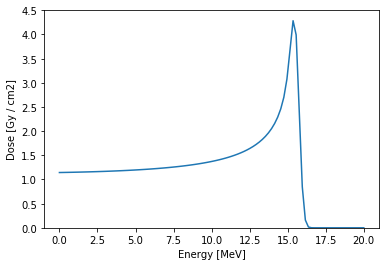

In [5]:
sigma_E_MeV = 1.0
z_cm = np.linspace(start=0.0, stop=20.0, num=100)
fluence_cm2 = 10**9

dose_Gy = BortfeldModel.dose_Gy(fluence_cm2, E_MeV, sigma_E_MeV, z_cm)
plt.xlabel("Energy [MeV]")
plt.ylabel("Dose [Gy / cm2]")
plt.plot(z_cm,dose_Gy)
plt.ylim(0,None)